In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd

from pydub import AudioSegment
from pydub.utils import mediainfo

import os
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
C:\Users\singh\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
speech = AudioSegment.from_wav('arctic_a0005.wav') #Read audio data from file
x = speech.get_array_of_samples() #samples x(t)
x_sr = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
mfcc = librosa.feature.mfcc(
    np.float32(x),
    sr = x_sr, #sampling rate of the signal, which is determined from the signal
    hop_length = int(x_sr * 0.015), #15 ms
    n_mfcc = 12 #number of mfcc features
)

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2183176522.py:4: FutureWarning: Pass y=[ 0.  0. -2. ... -1.  3.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


In [3]:
print(mfcc.shape)

(12, 95)


Text(0, 0.5, 'Amplitude')

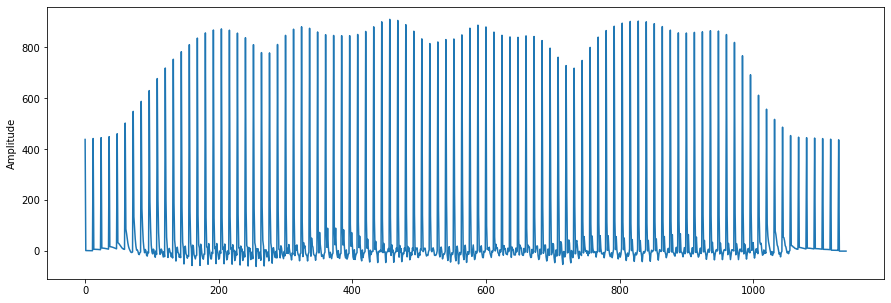

In [4]:
mfcc_flattened = np.reshape(mfcc.T, (mfcc.shape[0] * mfcc.shape[1]))
plt.figure(figsize = (15, 5))
plt.plot(mfcc_flattened)
plt.ylabel('Amplitude')

In [5]:
#emotions = ['Calm', 'Happy', 'Sad', 'Angry']
#path = 'EmotionSpeech/'
#training_file_names = []
#training_emotion_labels = []
#for i in range(0, len(emotions)):
#    sub_path = path + 'Train/' + emotions[i] + '/'
#    sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
#    sub_emotion_labels = [i] * len(sub_file_names)
#    training_file_names += sub_file_names
#    training_emotion_labels += sub_emotion_labels

In [6]:
def mfcc_extraction(audio_filename, #.wav filename
                    hop_duration, #hop_length in seconds, e.g., 0.015s (i.e., 15ms)
                    num_mfcc, #number of mfcc features
                    num_frames #number of frames
                   ):
    speech = AudioSegment.from_wav(audio_filename) #Read audio data from file
    samples = speech.get_array_of_samples() #samples x(t)
    sampling_rate = speech.frame_rate #sampling rate f - see slide 24 in week 7 lecture slides
    mfcc = librosa.feature.mfcc(
        np.float32(samples),
        sr = sampling_rate,
        hop_length = int(sampling_rate * hop_duration),
        n_mfcc = num_mfcc)
    mfcc_truncated = np.zeros((num_mfcc, num_frames), np.float32)
    for i in range(min(num_frames, mfcc.shape[1])):
        mfcc_truncated[:, i] = mfcc[:, i]
    
    #output is a vector including mfcc_truncated.shape[0] * mfcc_truncated.shape[1] elements
    return np.reshape(mfcc_truncated.T, mfcc_truncated.shape[0] * mfcc_truncated.shape[1])

In [7]:
emotions = ['Calm', 'Happy', 'Sad', 'Angry']
hop_duration = 0.015
num_mfcc_list = [12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

num_frames = 200
path = "EmotionSpeech/"

training_file_names = []
training_emotion_labels = []

for num_mfcc in num_mfcc_list:
    print("Using num mfcc: ", num_mfcc)
    for i in range(0, len(emotions)):
        sub_path = path + 'Train/' + emotions[i] + "/"
        sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
        sub_emotion_labels = [i] * len(sub_file_names)
        training_file_names += sub_file_names
        training_emotion_labels += sub_emotion_labels
    
    test_file_names = []
    test_emotion_labels = []
    for i in range(0, len(emotions)):
        sub_path = path + 'Test/' + emotions[i] + "/"
        sub_file_names = [os.path.join(sub_path, f) for f in os.listdir(sub_path)]
        sub_emotion_labels = [i] * len(sub_file_names)
        test_file_names += sub_file_names
        test_emotion_labels += sub_emotion_labels
    
    training_mfcc = []
    for filename in training_file_names:
        training_mfcc.append(mfcc_extraction(filename, hop_duration, num_mfcc, num_frames))
        
    test_mfcc = []
    for filename in test_file_names:
        test_mfcc.append(mfcc_extraction(filename, hop_duration, num_mfcc, num_frames))
    
    svm_classifier = svm.SVC(C=1, kernel = 'linear')
    svm_classifier.fit(training_mfcc, training_emotion_labels)
    predicted_emotion_labels = svm_classifier.predict(test_mfcc)
    print("SVM performance: ", np.sum(predicted_emotion_labels == test_emotion_labels)/ len(test_emotion_labels))
    cm = confusion_matrix(test_emotion_labels, predicted_emotion_labels)
    print("SVM confusion matrix\n ", cm)
    
    adb_classifier = AdaBoostClassifier(n_estimators=50, random_state=0)
    adb_classifier.fit(training_mfcc, training_emotion_labels)
    predicted_emotion_labels = adb_classifier.predict(test_mfcc)
    print("AdaBoostClassifier performance: ", np.sum(predicted_emotion_labels == test_emotion_labels)/ len(test_emotion_labels))
    cm = confusion_matrix(test_emotion_labels, predicted_emotion_labels)
    print("AdaBoostClassifier confusion matrix:\n ", cm)
    print("############################################################\n")
    

Using num mfcc:  12


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-5. -5. -5. ... -3. -3. -3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 3. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.6328125
SVM confusion matrix
  [[29  0  3  0]
 [ 4 12 14  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.4140625
AdaBoostClassifier confusion matrix:
  [[30  0  2  0]
 [13  0  9 10]
 [24  0  3  5]
 [ 4  0  8 20]]
############################################################

Using num mfcc:  14


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... 10. 10. 10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 1.  2.  2. ... -5. -4. -5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.6328125
SVM confusion matrix
  [[29  0  3  0]
 [ 4 12 14  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.3984375
AdaBoostClassifier confusion matrix:
  [[31  0  1  0]
 [14  1 10  7]
 [24  2  3  3]
 [ 4  4  8 16]]
############################################################

Using num mfcc:  16


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-5. -5. -5. ... -3. -3. -3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 1. 1. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 3. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 76. 75. 73.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... -1. -1. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.6328125
SVM confusion matrix
  [[29  0  3  0]
 [ 5 12 13  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.515625
AdaBoostClassifier confusion matrix:
  [[31  0  1  0]
 [ 8  1 13 10]
 [19  0 10  3]
 [ 0  4  4 24]]
############################################################

Using num mfcc:  18


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... 10. 10. 10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 1.  2.  2. ... -5. -4. -5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.6328125
SVM confusion matrix
  [[29  0  3  0]
 [ 5 12 13  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.5078125
AdaBoostClassifier confusion matrix:
  [[31  0  1  0]
 [ 4  1 17 10]
 [20  0  9  3]
 [ 0  4  4 24]]
############################################################

Using num mfcc:  20


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... 10. 10. 10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   0.  -1. ... -86. -71. -78.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-3. -3. -3. ...  6.  7.  6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-1.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


SVM performance:  0.6484375
SVM confusion matrix
  [[29  0  3  0]
 [ 5 14 11  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.5
AdaBoostClassifier confusion matrix:
  [[30  0  2  0]
 [ 6  1 15 10]
 [20  0  9  3]
 [ 0  4  4 24]]
############################################################

Using num mfcc:  22


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 3. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.640625
SVM confusion matrix
  [[29  0  3  0]
 [ 5 13 12  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.5
AdaBoostClassifier confusion matrix:
  [[30  0  2  0]
 [ 6  1 15 10]
 [20  0  9  3]
 [ 0  4  4 24]]
############################################################

Using num mfcc:  24


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... 10. 10. 10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 1.  2.  2. ... -5. -4. -5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... -1. -1. -2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\sin

SVM performance:  0.640625
SVM confusion matrix
  [[29  0  3  0]
 [ 5 13 12  2]
 [ 8  0 22  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.3671875
AdaBoostClassifier confusion matrix:
  [[28  0  4  0]
 [12  1 13  6]
 [20  0 10  2]
 [ 0  4 20  8]]
############################################################

Using num mfcc:  26


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 3. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.625
SVM confusion matrix
  [[29  0  3  0]
 [ 5 13 12  2]
 [10  0 20  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.4375
AdaBoostClassifier confusion matrix:
  [[27  0  5  0]
 [12  1  4 15]
 [20  4  5  3]
 [ 0  4  5 23]]
############################################################

Using num mfcc:  28


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-3. -5.  0. ...  4.  4.  5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0. -1. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 3. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -3. ...  4.  4.  4.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  10.   17.   12. ... -126. -127. -129.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 2. 2. 3.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 1. ... 0. 0. 1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 76. 75. 73.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\sin

SVM performance:  0.625
SVM confusion matrix
  [[30  0  2  0]
 [ 4 13 13  2]
 [10  0 20  2]
 [ 4  8  3 17]]
AdaBoostClassifier performance:  0.4453125
AdaBoostClassifier confusion matrix:
  [[27  0  5  0]
 [12  1  3 16]
 [20  3  6  3]
 [ 0  4  5 23]]
############################################################

Using num mfcc:  30


C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[1. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 1. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... -2. -1. -1.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\T

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-22. -23. -23. ...   0.   2.   2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-4. -4. -4. ...  0.  0.  0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[   0.    0.   -1. ... -357. -323.  -45.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 0.  0.  0. ... 81. 80. 80.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[2. 2. 2. ... 2. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 3. 2. 2.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -1. ... 10. 10. 10.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[ 1.  2.  2. ... -5. -4. -5.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\L

C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  0.   1.   1. ... -27. -26. -27.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[-2. -2. -2. ...  7. 14. 19.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[0. 0. 0. ... 6. 5. 6.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Users\singh\AppData\Local\Temp\ipykernel_14868\2905434834.py:9: FutureWarning: Pass y=[  2.   2.   3. ... -71. -71. -72.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(
C:\Use

SVM performance:  0.625
SVM confusion matrix
  [[30  0  2  0]
 [ 4 13 13  2]
 [11  0 19  2]
 [ 4  7  3 18]]
AdaBoostClassifier performance:  0.359375
AdaBoostClassifier confusion matrix:
  [[28  0  4  0]
 [ 9  0 15  8]
 [20  0  8  4]
 [ 0  2 20 10]]
############################################################

